# Install necessary libraries

In [ ]:
!pip3 install matplotlib pandas graphviz bs4 scikit-learn xgboost TextBlob textstat

# Import the libraries

In [2]:
import os
import re
import os
import tqdm
from glob import glob
import string

from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.discriminant_analysis import StandardScaler
from xgboost import XGBRegressor

import xgboost as xgb

from itertools import combinations
from sklearn.model_selection import cross_val_score
from textblob import TextBlob

import textstat

# HTML Parsing

Build the id to conversation dictionary

In [3]:
data_path = "data/html/*.html"

id_to_conversation = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:

    file_id = os.path.basename(path).split(".")[0]

    with open(path, "r", encoding="latin1") as file:
        html = file.read()
        soup = BeautifulSoup(html, "html.parser")

        conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})

        conversation_texts = []
        for i, conversation in enumerate(conversations):
            conversation = conversation.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            
            if len(conversation) > 0:
                role = conversation[0].get("data-message-author-role")
                conversation_texts.append(
                    {
                        "role" : role,
                        "text" : conversation[0].text
                    }
                )
        
        id_to_conversation[file_id] = conversation_texts


100%|██████████| 127/127 [00:15<00:00,  8.04it/s]


Example conversation element (message)

In [4]:
pprint(id_to_conversation["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


Build the id to user prompts dictionary, and collect all user prompts in a list

In [5]:
all_user_prompts = []

id_to_user_prompts = dict()

for id, conversation in id_to_conversation.items():
    user_prompts = []

    for message in conversation:
        if message["role"] == "user":
            all_user_prompts.append(message["text"])
            user_prompts.append(message["text"])
    
    id_to_user_prompts[id] = user_prompts


# Feature Engineering

Add features such as polarity, subjectivity, word count, character count, readability

In [6]:
for id, conversation in id_to_conversation.items():
    for message in conversation:
        if message["role"] == "user":
            text = message["text"]
            
            sentiment = TextBlob(text).sentiment
            word_count = len(text.split())
            char_count = len(text)
            readability_score = textstat.flesch_reading_ease(text)

            message['polarity'] = sentiment.polarity  # -1 to 1 where 1 means positive sentiment
            message['subjectivity'] = sentiment.subjectivity  # 0 to 1 where 1 means subjective
            message['word_count'] = word_count
            message['char_count'] = char_count
            message['readability_score'] = readability_score

In [7]:
id_to_conversation["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

{'role': 'user',
 'text': "Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n",
 'polarity': 0.0,
 'subjectivity': 0.0,
 'word_count': 40,
 'char_count': 269,
 'readability_score': 83.36}

Add features for some imporant word occurances

In [8]:
keywords = ['error', 'no', 'yes', 'but', 'why', 'right', 'wrong', 'true', 'false', 'correct', 'incorrect', 'how', 'can', 'try', 'again', 
            'of course', 'apologize', 'misunderstanding', 'clarify', 'provide', 'assist', 'valueerror', 'nameerror', 'keyerror', 'traceback']

id_to_keyword_count = {}

# Count the occurrences of each keyword in each conversation
for id, conversation in id_to_conversation.items():
    # Initialize keyword count for this conversation
    keyword_counts = {key: 0 for key in keywords}

    # Count keywords in each message of the conversation
    for message in conversation:
        text = message['text'].lower()
        for keyword in keywords:
            if keyword in text:
                keyword_counts[keyword] += 1

    # Store the counts for this conversation
    id_to_keyword_count[id] = keyword_counts
    

In [9]:
id_to_keyword_count["0031c86e-81f4-4eef-9e0e-28037abf9883"]

{'error': 7,
 'no': 21,
 'yes': 0,
 'but': 1,
 'why': 0,
 'right': 0,
 'wrong': 0,
 'true': 7,
 'false': 2,
 'correct': 5,
 'incorrect': 0,
 'how': 20,
 'can': 15,
 'try': 2,
 'again': 1,
 'of course': 0,
 'apologize': 1,
 'misunderstanding': 0,
 'clarify': 0,
 'provide': 15,
 'assist': 0,
 'valueerror': 4,
 'nameerror': 0,
 'keyerror': 2,
 'traceback': 0}

Add python code snippet count as a feature

In [10]:
# Define a function to count Python code snippets in a conversation
def count_python_snippets(conversation):
    snippet_count = 0
    for message in conversation:
        if "pythonCopy code" in message['text']:
            snippet_count += 1
    return snippet_count

# Apply the function to each conversation and store the results
id_to_snippet_count = {}
for id, conversation in id_to_conversation.items():
    id_to_snippet_count[id] = count_python_snippets(conversation)

id_to_snippet_count

{'0031c86e-81f4-4eef-9e0e-28037abf9883': 14,
 '0225686d-b825-4cac-8691-3a3a5343df2b': 17,
 '041f950b-c013-409a-a642-cffff60b9d4b': 7,
 '04f91058-d0f8-4324-83b2-19c671f433dc': 18,
 '089eb66d-4c3a-4f58-b98f-a3774a2efb34': 78,
 '090d6217-5d69-4929-a342-19abab78324f': 67,
 '0c95c563-f1e1-4a35-844c-2e8ccdd1b161': 12,
 '0ddfae9c-0dbd-4fbe-9e68-c3e0cb73b8fc': 10,
 '0e466794-f7f8-4cc2-b07e-070b13a0b5e1': 30,
 '0f0c953a-a472-47c1-809b-9fc14dba9091': 15,
 '1029802d-1057-4e3e-b827-e8a9c2ded3b9': 47,
 '1038cb22-8ad2-4030-b44a-59f10352e91c': 55,
 '106ffe99-c787-4d09-9076-4ba411eb68b1': 17,
 '139235c7-736c-4237-92f0-92e8c116832c': 0,
 '14ce054d-4619-4685-ba9b-4b5cd6f81b2d': 8,
 '152a7787-ecd1-448f-a98e-8af0826d8215': 28,
 '17bd62e7-6792-4399-a573-07456a73901b': 36,
 '1b54e38b-3b1d-425e-835a-d1e0fb2694fc': 16,
 '223ae726-cb25-49df-a125-c4af3519c8e8': 13,
 '22bb7162-3399-464a-b30b-cf1fc3210b4e': 16,
 '2446216c-c557-4ee8-b470-7e2ae3c88968': 4,
 '24f01035-0717-4256-9952-c415aa8ecd10': 46,
 '26d95379-e2f

Faulty HTML files, we will discard these

In [11]:
faulty_ids = []

for id, user_prompts in id_to_user_prompts.items():
    if len(user_prompts) == 0:
        faulty_ids.append(id)

pprint(faulty_ids)


['139235c7-736c-4237-92f0-92e8c116832c',
 '668ad17e-0240-49f7-b5a7-d22e502554c6',
 'b0640e51-6879-40cb-a4f5-329f952ef99d',
 'da6b70d5-29f6-491a-ad46-037c77067128']


Introduce features num_prompts, prompt_avg_chars, response_avg_chars

In [12]:
id_to_features = defaultdict(lambda : defaultdict(int))

for id, conversation in id_to_conversation.items():
    if id in faulty_ids:
        continue
    for message in conversation:
        text = message["text"].lower()
        if message["role"] == "user":
            # User Prompts
            id_to_features[id]["num_prompts"] += 1
            id_to_features[id]["prompt_avg_chars"] += len(text)
            id_to_features[id]["polarity"] += message["polarity"]
            id_to_features[id]["subjectivity"] += message["subjectivity"]
            id_to_features[id]["word_count"] += message["word_count"]
            id_to_features[id]["readability_score"] += message["readability_score"]
        else:
            # ChatGPT Responses
            id_to_features[id]["response_avg_chars"] += len(text)

    id_to_features[id]["prompt_avg_chars"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["response_avg_chars"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["polarity"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["subjectivity"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["word_count"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["readability_score"] /= id_to_features[id]["num_prompts"]


id_to_features["0031c86e-81f4-4eef-9e0e-28037abf9883"]

defaultdict(int,
            {'num_prompts': 14,
             'prompt_avg_chars': 407.2142857142857,
             'polarity': 0.1394573283858998,
             'subjectivity': 0.4221706864564007,
             'word_count': 63.07142857142857,
             'readability_score': 53.98357142857143,
             'response_avg_chars': 2218.5})

Homework questions list

In [13]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

# Prompt Matching

Vector representation of all words in the user prompts and questions

In [14]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(all_user_prompts + questions)

Build TF-IDF of the questions

In [15]:
questions_tf_idf = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_tf_idf.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build TF-IDF of the user prompts, and put them in a id to user prompt TF-IDF dictionary

In [16]:
id_to_user_prompts_tf_idf = dict()
for id, user_prompts in id_to_user_prompts.items():
    if id in faulty_ids:
        # Skip the faulty ids
        continue
    user_prompts_tf_idf = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    id_to_user_prompts_tf_idf[id] = user_prompts_tf_idf

id_to_user_prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()


,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Build id to cosine similarities dictionary

In [17]:
id_to_cosine_similarities = dict()
for id, user_prompts_tf_idf in id_to_user_prompts_tf_idf.items():
    id_to_cosine_similarities[id] = pd.DataFrame(cosine_similarity(questions_tf_idf, user_prompts_tf_idf))
    

The values of this dictionary are the prompts of the user and their cosine similarity with the questions

In [18]:
id_to_cosine_similarities["0031c86e-81f4-4eef-9e0e-28037abf9883"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.098331,0.145934,0.133569,0.101900,0.107860,0.081455,0.095065,0.104121,0.053214,0.122190,0.137112,0.103822,0.057262,0.153541
1,0.294879,0.210561,0.121038,0.113037,0.088047,0.017431,0.050606,0.083280,0.014352,0.037618,0.057881,0.031450,0.008575,0.061691
2,0.027429,0.522169,0.355681,0.192669,0.170000,0.027897,0.186540,0.165127,0.075550,0.107865,0.182409,0.099605,0.058235,0.143677
3,0.068510,0.172910,0.190213,0.352243,0.148608,0.015504,0.122209,0.165345,0.101669,0.080874,0.197014,0.104888,0.091882,0.170255
4,0.034614,0.136127,0.102305,0.149459,0.336574,0.062700,0.256655,0.300427,0.226412,0.366737,0.460606,0.063362,0.028518,0.137036
5,0.011787,0.094092,0.150838,0.092254,0.099366,0.033225,0.091203,0.072604,0.055960,0.106945,0.099189,0.064705,0.021645,0.553876
6,0.027324,0.144124,0.132853,0.114934,0.085751,0.022912,0.059039,0.085772,0.034990,0.054441,0.118040,0.054354,0.035546,0.167250
7,0.029217,0.173920,0.182938,0.159102,0.108855,0.041527,0.081156,0.054752,0.027771,0.077381,0.138861,0.071743,0.028561,0.125639
8,0.011721,0.195440,0.050756,0.080464,0.076226,0.077046,0.085161,0.058973,0.018552,0.106451,0.086552,0.089830,0.075412,0.097044


Build the id to question similarity dictionary

In [19]:
id_to_question_similarities = dict()
for id, cosine_similarities in id_to_cosine_similarities.items():
    # Across all prompts of this user, get the maximum cosine similarity for each question
    id_to_question_similarities[id] = id_to_cosine_similarities[id].max(axis=1).tolist()

id_to_question_similarities["0031c86e-81f4-4eef-9e0e-28037abf9883"]

[0.15354089378499097,
 0.2948791719118865,
 0.5221693252600499,
 0.35224306559042085,
 0.4606063455402358,
 0.5538756543429254,
 0.16725042992671718,
 0.18293808775235298,
 0.19543980723403126]

## Create the dataframe

Now we will combine all the features and create a dataframe

Build the all question similarities dataframe. This dataframe rows contain the user id, and the maximum cosine similarity for each question across all prompts of this user

In [20]:
df = pd.DataFrame(id_to_question_similarities).T
df.reset_index(inplace=True)
df.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
df.rename(columns={"index" : "id"}, inplace=True)

df.head()

,id,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


In [21]:
df2 = pd.DataFrame(id_to_features).T
df2.reset_index(inplace=True, drop=False)
df2.rename(columns={"index": "id"}, inplace=True)
df2.head()

,id,num_prompts,prompt_avg_chars,polarity,subjectivity,word_count,readability_score,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,407.214286,0.139457,0.422171,63.071429,53.983571,2218.500000
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,261.111111,0.130718,0.267261,39.388889,53.115556,1653.111111
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,663.000000,-0.021337,0.274960,97.555556,55.614444,1636.222222
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,114.100000,0.004042,0.225458,17.750000,66.300000,1749.900000
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,217.081395,0.089507,0.308600,28.767442,56.105116,1455.441860


In [22]:
df3 = pd.DataFrame(id_to_keyword_count).T
df3.reset_index(inplace=True, drop=False)
df3.rename(columns={"index": "id"}, inplace=True)
df3.head()

,id,error,no,yes,but,why,right,wrong,true,false,...,of course,apologize,misunderstanding,clarify,provide,assist,valueerror,nameerror,keyerror,traceback
0,0031c86e-81f4-4eef-9e0e-28037abf9883,7,21,0,1,0,0,0,7,2,...,0,1,0,0,15,0,4,0,2,0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0,19,0,6,2,1,0,4,2,...,0,0,0,0,6,5,0,0,0,0
2,041f950b-c013-409a-a642-cffff60b9d4b,7,13,0,2,1,4,0,4,2,...,0,4,0,0,1,1,0,2,1,0
3,04f91058-d0f8-4324-83b2-19c671f433dc,2,19,0,2,0,0,0,7,3,...,0,1,0,0,5,0,1,0,0,0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,13,107,2,27,4,23,2,23,0,...,0,4,0,4,19,12,1,1,0,6


Let's merge all these dataframes

In [23]:
df = pd.merge(df, df2, on="id", how="left")
df = pd.merge(df, df3, on="id", how="left")
df.head()

,id,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,...,of course,apologize,misunderstanding,clarify,provide,assist,valueerror,nameerror,keyerror,traceback
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,...,0,1,0,0,15,0,4,0,2,0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,...,0,0,0,0,6,5,0,0,0,0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,...,0,4,0,0,1,1,0,2,1,0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,...,0,1,0,0,5,0,1,0,0,0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,...,0,4,0,4,19,12,1,1,0,6


Read the grades

In [24]:
grades = pd.read_csv("data/scores.csv", sep=",")
grades["id"] = grades["code"].apply(lambda x: x.strip())
grades = grades[["id", "grade"]]
grades.head()

,id,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


Grade distribution

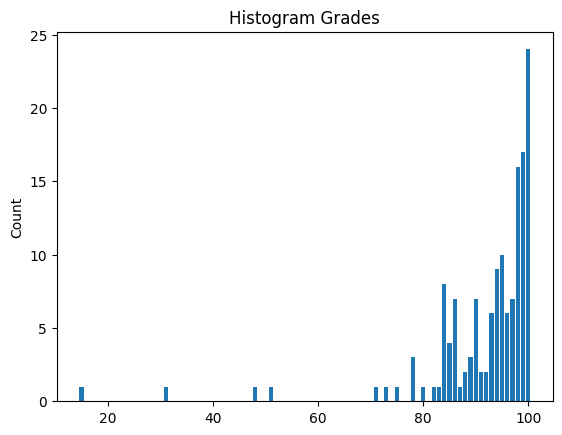

In [25]:
plt.title('Histogram Grades')
plt.hist(grades["grade"], rwidth=.8, bins=np.arange(min(grades["grade"]), max(grades["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

Merge with grades

In [26]:
df = pd.merge(df, grades, on="id", how="left")
df.dropna(inplace=True)
df.drop_duplicates("id", inplace=True, keep="first")
df.head()

,id,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,...,apologize,misunderstanding,clarify,provide,assist,valueerror,nameerror,keyerror,traceback,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,...,1,0,0,15,0,4,0,2,0,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,...,0,0,0,6,5,0,0,0,0,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,...,4,0,0,1,1,0,2,1,0,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,...,1,0,0,5,0,1,0,0,0,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,...,4,0,4,19,12,1,1,0,6,100.0


# Building the Model

### Train / Test Split

In [27]:
# Separate features (X) and target variable (y)
X = df.drop(['id', 'grade'], axis=1)
y = df['grade']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the XGBoost model and predict on test set

Also add a post processing to the predictions so that they are an integer between 0 and 100

In [28]:
def post_process_predictions(predictions):
    predictions = np.clip(predictions, 0, 100)
    predictions = np.round(predictions).astype(int)
    return predictions

model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=2, random_state=42)
model.fit(X_train, y_train)

y_pred = post_process_predictions(model.predict(X_test))

### Evaluate the model and the features

In [29]:
y_train_pred = post_process_predictions(model.predict(X_train))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST:", r2_score(y_test, y_pred))

MSE Train: 0.2268041237113402
MSE TEST: 38.88
R2 Train: 0.9986121426462421
R2 TEST: 0.653678419747456


In [30]:
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
print('\nFeature Importances:')
print(feature_importances)


Feature Importances:
               Feature  Importance
0                  Q_0    0.017303
1                  Q_1    0.007595
2                  Q_2    0.015481
3                  Q_3    0.003228
4                  Q_4    0.037433
5                  Q_5    0.020730
6                  Q_6    0.010614
7                  Q_7    0.009934
8                  Q_8    0.016053
9          num_prompts    0.077042
10    prompt_avg_chars    0.338432
11            polarity    0.008759
12        subjectivity    0.020723
13          word_count    0.037030
14   readability_score    0.022666
15  response_avg_chars    0.010841
16               error    0.008664
17                  no    0.003180
18                 yes    0.005605
19                 but    0.218340
20                 why    0.000000
21               right    0.004264
22               wrong    0.000000
23                true    0.001291
24               false    0.009562
25             correct    0.001086
26           incorrect    0.00402

In [31]:
# Define the error range
error_range = 10

# Check how many predictions fall within the error range
correct_predictions = 0

for true_grade, predicted_grade in zip(y_test, y_pred):
    if abs(true_grade - predicted_grade) <= error_range:
        correct_predictions += 1

# Calculate the percentage of correct predictions within the error range
percentage_correct = (correct_predictions / len(y_test)) * 100

# Print the results
print(f'Percentage of IDs with Predictions within ±{error_range} Points: {percentage_correct}%')

Percentage of IDs with Predictions within ±10 Points: 88.0%


Test set real grades vs predicted grades

In [32]:
# Create a DataFrame with user IDs, real grades, and predicted grades
results_df = pd.DataFrame({
    'Real Grade': y_test.values,
    'Predicted Grade': y_pred
})

# Print the results
print(results_df)

    Real Grade  Predicted Grade
0         96.0               91
1         91.0               88
2         97.0               95
3         88.0               92
4        100.0               99
5         97.0               94
6        100.0               99
7         95.0               91
8         94.0               97
9         90.0               90
10        86.0               97
11        98.0               96
12        94.0               97
13        78.0               97
14        98.0               93
15       100.0              100
16        86.0               97
17        97.0               92
18        90.0              100
19        48.0               53
20        87.0               88
21       100.0               93
22        99.0               95
23       100.0               96
24        94.0               91


# Predict every sample

We will process the HTML files that do not have their grades available, and predict their grades. The code below is for creating the dataframe X. For prediction, it uses the model trained above.

In [33]:
data_path = "data/chatgpt_data/*.html"

id_to_conversation = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:

    file_id = os.path.basename(path).split(".")[0]

    with open(path, "r", encoding="latin1") as file:
        html = file.read()
        soup = BeautifulSoup(html, "html.parser")

        conversations = soup.find_all("div", attrs={"data-testid": re.compile(r"conversation-turn-[0-9]+")})

        conversation_texts = []
        for i, conversation in enumerate(conversations):
            conversation = conversation.find_all("div", attrs={"data-message-author-role": re.compile(r"[user|assistant]")})
            
            if len(conversation) > 0:
                role = conversation[0].get("data-message-author-role")
                conversation_texts.append(
                    {
                        "role" : role,
                        "text" : conversation[0].text
                    }
                )
        
        id_to_conversation[file_id] = conversation_texts

all_user_prompts = []

id_to_user_prompts = dict()

for id, conversation in id_to_conversation.items():
    user_prompts = []

    for message in conversation:
        if message["role"] == "user":
            all_user_prompts.append(message["text"])
            user_prompts.append(message["text"])
    
    id_to_user_prompts[id] = user_prompts

for id, conversation in id_to_conversation.items():
    for message in conversation:
        if message["role"] == "user":
            text = message["text"]
            
            sentiment = TextBlob(text).sentiment
            word_count = len(text.split())
            char_count = len(text)
            readability_score = textstat.flesch_reading_ease(text)

            message['polarity'] = sentiment.polarity  # -1 to 1 where 1 means positive sentiment
            message['subjectivity'] = sentiment.subjectivity  # 0 to 1 where 1 means subjective
            message['word_count'] = word_count
            message['char_count'] = char_count
            message['readability_score'] = readability_score

keywords = ['error', 'no', 'yes', 'but', 'why', 'right', 'wrong', 'true', 'false', 'correct', 'incorrect', 'how', 'can', 'try', 'again', 
            'of course', 'apologize', 'misunderstanding', 'clarify', 'provide', 'assist', 'valueerror', 'nameerror', 'keyerror', 'traceback']

id_to_keyword_count = {}

# Count the occurrences of each keyword in each conversation
for id, conversation in id_to_conversation.items():
    # Initialize keyword count for this conversation
    keyword_counts = {key: 0 for key in keywords}

    # Count keywords in each message of the conversation
    for message in conversation:
        text = message['text'].lower()
        for keyword in keywords:
            if keyword in text:
                keyword_counts[keyword] += 1

    # Store the counts for this conversation
    id_to_keyword_count[id] = keyword_counts

# Define a function to count Python code snippets in a conversation
def count_python_snippets(conversation):
    snippet_count = 0
    for message in conversation:
        if "pythonCopy code" in message['text']:
            snippet_count += 1
    return snippet_count

# Apply the function to each conversation and store the results
id_to_snippet_count = {}
for id, conversation in id_to_conversation.items():
    id_to_snippet_count[id] = count_python_snippets(conversation)

faulty_ids = []

for id, user_prompts in id_to_user_prompts.items():
    if len(user_prompts) == 0:
        faulty_ids.append(id)

id_to_features = defaultdict(lambda : defaultdict(int))

for id, conversation in id_to_conversation.items():
    if id in faulty_ids:
        continue
    for message in conversation:
        text = message["text"].lower()
        if message["role"] == "user":
            # User Prompts
            id_to_features[id]["num_prompts"] += 1
            id_to_features[id]["prompt_avg_chars"] += len(text)
            id_to_features[id]["polarity"] += message["polarity"]
            id_to_features[id]["subjectivity"] += message["subjectivity"]
            id_to_features[id]["word_count"] += message["word_count"]
            id_to_features[id]["readability_score"] += message["readability_score"]
        else:
            # ChatGPT Responses
            id_to_features[id]["response_avg_chars"] += len(text)

    id_to_features[id]["prompt_avg_chars"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["response_avg_chars"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["polarity"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["subjectivity"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["word_count"] /= id_to_features[id]["num_prompts"]
    id_to_features[id]["readability_score"] /= id_to_features[id]["num_prompts"]

questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
#####################
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(all_user_prompts + questions)

questions_tf_idf = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())

id_to_user_prompts_tf_idf = dict()
for id, user_prompts in id_to_user_prompts.items():
    if id in faulty_ids:
        # Skip the faulty ids
        continue
    user_prompts_tf_idf = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    id_to_user_prompts_tf_idf[id] = user_prompts_tf_idf

id_to_cosine_similarities = dict()
for id, user_prompts_tf_idf in id_to_user_prompts_tf_idf.items():
    id_to_cosine_similarities[id] = pd.DataFrame(cosine_similarity(questions_tf_idf, user_prompts_tf_idf))

id_to_question_similarities = dict()
for id, cosine_similarities in id_to_cosine_similarities.items():
    # Across all prompts of this user, get the maximum cosine similarity for each question
    id_to_question_similarities[id] = id_to_cosine_similarities[id].max(axis=1).tolist()

df = pd.DataFrame(id_to_question_similarities).T
df.reset_index(inplace=True)
df.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
df.rename(columns={"index" : "id"}, inplace=True)

df2 = pd.DataFrame(id_to_features).T
df2.reset_index(inplace=True, drop=False)
df2.rename(columns={"index": "id"}, inplace=True)

df3 = pd.DataFrame(id_to_keyword_count).T
df3.reset_index(inplace=True, drop=False)
df3.rename(columns={"index": "id"}, inplace=True)

df = pd.merge(df, df2, on="id", how="left")
df = pd.merge(df, df3, on="id", how="left")

def post_process_predictions(predictions):
    predictions = np.clip(predictions, 0, 100)
    predictions = np.round(predictions).astype(int)
    return predictions

X_new = df.drop(['id'], axis=1)
y_new = model.predict(X_new)
y_new = post_process_predictions(y_new)

100%|██████████| 188/188 [00:40<00:00,  4.70it/s]


Examine the predictions

In [34]:
predictions_df = pd.DataFrame({'id': df['id'], 'predicted_grade': y_new})
result_df = pd.merge(df, predictions_df, on='id', how='left')
result_df = result_df[['id', 'predicted_grade']]

print(result_df)

                                       id  predicted_grade
0    00941713-c3a2-4d27-81dc-cd447ace4a47               49
1    00aea02f-a95a-4c04-8be3-777461732cdf               83
2    04fdb619-d902-4e98-a5e9-a8198bfe047c               98
3    05029661-f8d8-441b-9cab-3c79f28a8b26               99
4    059a146e-a37c-498f-8c0b-5a78204249cb               90
..                                    ...              ...
183  fab774ac-38c8-4d86-910c-7ad0fa8470c5               96
184  fac3042d-d72d-43a7-9170-a424e3061fac               90
185  fbf473eb-ea6f-4a4a-b2d8-405bc09f9850               96
186  fccd270d-63f8-42b6-b73e-13f6d3e5f612               95
187  fe81cca3-d9c2-4d82-97a4-9cc1444ea219               98

[188 rows x 2 columns]


Output the predictions to a file

In [35]:
result_df['id'] = result_df['id'] + '.html'
result_df.to_csv('predictions.txt', index=False, header=False, columns=['id', 'predicted_grade'])